In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, models, layers, Input

from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Layer, Add, Dropout, LeakyReLU, ReLU, AveragePooling2D, Activation
from keras.regularizers import l2
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.callbacks import LearningRateScheduler
from keras.utils import load_img, img_to_array
from keras import optimizers

import os
import av
import shutil
import imghdr
import random
from PIL import Image
import pickle
import numpy as np
import math

from scipy.special import softmax
import matplotlib.pyplot as plt

2023-05-06 12:15:33.200330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 12:15:35.411075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.get_visible_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-06 12:15:40.007206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 12:15:41.293285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 12:15:41.293460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
DS_CDFV1 = 'celeb_df_v1/'
DS_CDFV2 = 'celeb_df_v2/'

DS_ORGINAL = 'dataset_original/'
DS_SPLIT = 'dataset_split/'
DS_IFRAMES = 'dataset_iframes/'
DS_FACE = 'dataset_face/'
DS_FACE_IMG = 'dataset_face_img/'
DS_SRM_SNIPPETS = 'dataset_srm_snippets_5/'
DS_SEGMENTS = 'dataset_segments/'
DS_RAW = 'dataset_raw/'
DS_RESIDUALS = 'dataset_residuals/'
DS_TEMPORAL = 'dataset_temporal/'

DS_FRAME_DIFF = 'dataset_frame_diff/'
DS_FRAME_DIFF_IMG = 'dataset_frame_diff_img/'

DS_SEG_COUNT_1 = '1_segment/'
DS_SEG_COUNT_2 = '2_segments/'
DS_SEG_COUNT_3 = '3_segments/'
DS_SEG_COUNT_4 = '4_segments/'
DS_SEG_COUNT_5 = '5_segments/'

SEG_COUNT = [DS_SEG_COUNT_1, DS_SEG_COUNT_2, DS_SEG_COUNT_3, DS_SEG_COUNT_4, DS_SEG_COUNT_5]

SEG_1 = 'seg_1/'
SEG_2 = 'seg_2/'
SEG_3 = 'seg_3/'
SEG_4 = 'seg_4/'
SEG_5 = 'seg_5/'

SEG = ['seg_1_', 'seg_2_', 'seg_3_', 'seg_4_', 'seg_5_']

DS_TRAIN = 'train_dataset/'
DS_TEST = 'test_dataset/'
DS_VAL = 'val_dataset/'

CLASS_FAKE = 'fake/'
CLASS_REAL = 'real/'


TOP_LEVEL_1 = [DS_SPLIT, DS_IFRAMES, DS_FACE, DS_FACE_IMG, DS_SRM_SNIPPETS]
TOP_LEVEL_2 = [DS_SEGMENTS, DS_RAW, DS_RESIDUALS]
SEGMENTS = [SEG_1, SEG_2, SEG_3, SEG_4, SEG_5]
SPLIT = [DS_TRAIN, DS_TEST, DS_VAL]
CLASS = [CLASS_REAL, CLASS_FAKE]

DATASET = [DS_CDFV1, DS_CDFV2]

In [4]:
SAVE_CHECKPOINT_PATH = 'models/TEMPORAL_MODEL/checkpoints/'
SAVE_METRICS_PATH = 'models/TEMPORAL_MODEL/metrics/'
SAVE_MODEL_PATH = 'models/TEMPORAL_MODEL/final_model/'
BACKUP_MODEL_PATH = 'models/TEMPORAL_MODEL/backups/'

TEST_SCORE_PATH = 'test_scores/'

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Frame Extraction

## 10-04-2023

In [6]:
# Returns the index of frames that begin a new segment (except the first segment)
def get_segment_dividers(frame_count, num_segments):
    segments_per_frame = math.floor(frame_count / num_segments)

    return [(segments_per_frame * i) for i in range(1, num_segments) ]

In [7]:
# Returns the indices of the frames that will be randomly selected from each segment
# Multiple snippets indices per segment can be returned by setting the num_snippets arg 
def get_snippet_indices(segment_dividers, num_snippets):
    start_index = 0
    num_snippets = 1 if num_snippets <= 0 else num_snippets

    snippet_indices = []
    for end_index in segment_dividers:

        # Extracting multiple snippets per segment (if needed)
        for _ in range(num_snippets):
            snippet_indices.append(random.randint(start_index, end_index - 1))

        start_index = end_index
        
    return snippet_indices

In [8]:
# Returns an array of randomly selected snippets(PIL.Image) from each segment of the input video
def extract_snippets(fp, num_segments, num_snippets):
    vid_container = av.open(fp)
    vid_stream = vid_container.streams.video[0]
    frame_count = vid_stream.frames

    snippets = []

    # If number of frames in video is less than the number of frames that need to sampled
    # then take all frames in the video
    if frame_count < num_segments * num_snippets:
        for frame in vid_container.decode():
            snippets.append(frame.to_image())

    else:
        segment_dividers = get_segment_dividers(frame_count, num_segments)
        segment_dividers = segment_dividers + [frame_count]

        snippet_indices = get_snippet_indices(segment_dividers, num_snippets)

        frame_index = 0
        for frame in vid_container.decode():
            if frame_index > max(snippet_indices):
                break

            if frame_index in snippet_indices:
                snippets.append(frame.to_image())

            frame_index += 1

    return snippets

In [5]:
def extract_frames_from_video(fp):
    vid_container = av.open(fp)

    frames = []
    for frame in vid_container.decode():
        frames.append(frame.to_image())

    return frames

In [64]:
def create_image_dataset(dataset):
    assert dataset == DS_CDFV1 or dataset == DS_CDFV2

    src_base_path = dataset + DS_FRAME_DIFF
    dst_base_path = dataset + DS_FRAME_DIFF_IMG

    for split in SPLIT:
        print(f'---Split started: {split}---')

        for class_dir in CLASS:
            print(f'Class started: {class_dir}')

            for video in os.listdir(src_base_path + split + class_dir):
                fp = src_base_path + split + class_dir + video
                frames = extract_frames_from_video(fp)

                for i, frame in enumerate(frames, start=1):
                    frame = frame.resize((224, 224))
                    dst = f'{dst_base_path + split + class_dir + os.path.splitext(video)[0]}_f{i}.jpeg'
                    frame.save(dst)

In [66]:
create_image_dataset(DS_CDFV2)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


In [67]:
real_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_REAL))
fake_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_FAKE))
fake_files = os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_FAKE)

TMP_STORAGE = DS_CDFV2 + DS_FRAME_DIFF_IMG + 'ST_TRAIN/' + CLASS_FAKE
rem_samples = random.sample(fake_files, fake_count - 20000)

for sample in rem_samples:
    shutil.move(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_FAKE + sample, TMP_STORAGE + sample)

In [68]:
real_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_REAL))
fake_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_FAKE))
fake_files = os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_FAKE)

TMP_STORAGE = DS_CDFV2 + DS_FRAME_DIFF_IMG + 'ST_TRAIN/' + CLASS_FAKE
rem_samples = random.sample(fake_files, fake_count - 5000)

for sample in rem_samples:
    shutil.move(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_FAKE + sample, TMP_STORAGE + sample)

In [483]:
def create_tensor_dataset(dataset, split):
    ds = keras.utils.image_dataset_from_directory(
        directory = dataset + DS_FRAME_DIFF_IMG + split,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 32,
        color_mode = 'rgb',
        shuffle = True,
        image_size = (224, 224),
        seed = 1
    )

    return ds

In [484]:
# Celeb DF v2 Dataset

train_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TRAIN)
test_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TEST)
val_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_VAL)

Found 38950 files belonging to 2 classes.
Found 16239 files belonging to 2 classes.
Found 9714 files belonging to 2 classes.


## OLD

In [ ]:
for dataset in DATASET:
    for split in SPLIT:
        if split is DS_TEST:
            for segment in SEGMENTS:
                for label_class in CLASS:
                    dir = dataset + DS_TEMPORAL + split + segment + label_class
                    os.makedirs(dir, exist_ok=True) 
        else:
            for label_class in CLASS:
                dir = dataset + DS_TEMPORAL + split + label_class
                os.makedirs(dir, exist_ok=True)

In [ ]:
# List of testing videos
for src_dir in DATASET:
    for label, class_label in enumerate(CLASS):
        with open(src_dir + DS_TEMPORAL + 'testing_videos.txt', 'a+') as f:
            for file in os.listdir(src_dir + DS_SPLIT + DS_TEST + class_label):
                f.write(f'{file} {label}\n')

### Test Dataset

In [ ]:
def extract_frames_test(ds, dest_dir, segment, split, label, file):
    src_dir = ds + DS_RESIDUALS + segment + split + label

    for index, curr_segment in enumerate(SEGMENTS):
        if curr_segment > segment:
            break

        residual_file = src_dir + SEG[index] + file
        os.makedirs(dest_dir + SEGMENTS[index], exist_ok=True)

        vid = av.open(residual_file)

        for count, frame in enumerate(vid.decode()):
            image = frame.to_image()
            image.save(f'{dest_dir}{SEGMENTS[index]}frame_{count}.jpg')

In [ ]:
def extract_segment_frames(ds, segment):
    file = open(ds + DS_TEMPORAL + 'testing_videos.txt', 'r')
    videos = file.readlines()

    for video in videos:
        [file, label] = video.split(' ')
        label = CLASS_REAL if int(label) == 0 else CLASS_FAKE
        
        dest_dir = ds + DS_TEMPORAL + DS_TEST + segment + label + '/' + file +'/'
        os.makedirs(dest_dir, exist_ok=True)

        extract_frames_test(ds, dest_dir, segment, DS_TEST, label, file)    

In [ ]:
extract_segment_frames(DS_CDFV1, SEG_2)

### Training and Validation Dataset

In [ ]:
def extract_frames_train_val(ds):
    for split in SPLIT:
        if split == DS_TEST:
            continue
        else:
            for label_class in CLASS:
                src_dir = ds + DS_RESIDUALS + SEG_1 + split + label_class
                dest_dir = ds + DS_TEMPORAL + split + label_class
            
                for id, video in enumerate(os.listdir(src_dir)):
                    vid = av.open(src_dir + video)

                    for count, frame in enumerate(vid.decode()):
                        image = frame.to_image()
                        image.save(f'{dest_dir}frame_{count}_vid_{id}.jpg')

In [ ]:
extract_frames_train_val(DS_CDFV1)

## 3-05-2022

In [18]:
def create_train_val_dataset(src_dir, dest_dir, random_frame_count):

	for video in os.listdir(src_dir):
		video_container = av.open(src_dir + video)
		
		frame_count = video_container.streams.video[0].frames
		
		# if frame_count < random_frame_count:
		print(f'{video} {frame_count}')
		
		# continue
		# random_frame_count = frame_count if frame_count < random_frame_count else random_frame_count

		random_frames = random.sample(range(frame_count), random_frame_count)

		parent_name = video.split('.')[0]

		for index, frame in enumerate(video_container.decode()):
			if index in random_frames:
				image = frame.to_image()
				image.save(f'{dest_dir}{parent_name}_{index}.jpg')

In [21]:
src_dir = DS_CDFV2 + 'dataset_temporal_new/' + DS_VAL + CLASS_FAKE
dest_dir = DS_CDFV2 + 'dataset_temporal_new/' + 'val_ds/' + CLASS_FAKE
random_frame_count = 5

In [22]:
create_train_val_dataset(src_dir, dest_dir, random_frame_count)

seg_1_id1_id17_0001.mp4 272
seg_1_id29_id30_0007.mp4 306
seg_1_id39_id43_0002.mp4 310
seg_1_id23_id16_0005.mp4 308
seg_1_id40_id42_0008.mp4 310
seg_1_id40_id39_0008.mp4 310
seg_1_id20_id32_0008.mp4 338
seg_1_id58_id55_0008.mp4 388
seg_1_id37_id26_0001.mp4 290
seg_1_id34_id37_0008.mp4 516
seg_1_id4_id35_0006.mp4 302
seg_1_id1_id17_0003.mp4 451
seg_1_id26_id16_0004.mp4 350
seg_1_id29_id33_0000.mp4 429
seg_1_id1_id16_0006.mp4 505
seg_1_id51_id49_0001.mp4 408
seg_1_id9_id3_0006.mp4 401
seg_1_id30_id35_0004.mp4 404
seg_1_id52_id49_0000.mp4 377
seg_1_id28_id32_0000.mp4 330
seg_1_id23_id3_0006.mp4 314
seg_1_id40_id46_0001.mp4 320
seg_1_id23_id29_0005.mp4 308
seg_1_id53_id50_0003.mp4 472
seg_1_id52_id53_0001.mp4 466
seg_1_id16_id17_0003.mp4 303
seg_1_id54_id53_0003.mp4 314
seg_1_id16_id6_0009.mp4 315
seg_1_id49_id51_0005.mp4 479
seg_1_id39_id44_0009.mp4 313
seg_1_id23_id28_0003.mp4 186
seg_1_id40_id48_0005.mp4 322
seg_1_id27_id26_0002.mp4 340
seg_1_id37_id3_0003.mp4 353
seg_1_id9_id2_0009.mp4 

# 5-05-2022

In [53]:
def flip_horizontal(dir, file):
    parent_name = file.split('.')[0]
    img = Image.open(dir + file)
    img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
    img_flipped.save(f'{dir}{parent_name}_flipped.jpg')

In [63]:
def rotate_img(dir, file):
    parent_name = file.split('.')[0]
    img = Image.open(dir + file)

    rotated_img = img.rotate(45)
    rotated_img.save(f'{dir}{parent_name}_r45.jpg') 

    # rotated_img = img.rotate(-45)
    # rotated_img.save(f'{dir}{parent_name}_r-45.jpg') 

    # rotated_img = img.rotate(35)
    rotated_img.save(f'{dir}{parent_name}_r35.jpg') 

    # rotated_img = img.rotate(-35)
    # rotated_img.save(f'{dir}{parent_name}_r-35.jpg') 

    rotated_img = img.rotate(25)
    rotated_img.save(f'{dir}{parent_name}_r25.jpg') 

    # rotated_img = img.rotate(-25)
    # rotated_img.save(f'{dir}{parent_name}_r-25.jpg')
    
    # rotated_img = img.rotate(15)
    # rotated_img.save(f'{dir}{parent_name}_r15.jpg') 

    # rotated_img = img.rotate(-15)
    # rotated_img.save(f'{dir}{parent_name}_r-15.jpg') 

In [64]:
dir = DS_CDFV2 + 'dataset_face_residuals_acc_on/' + DS_VAL + CLASS_REAL

In [65]:
for img in os.listdir(dir):
    print(img)
    flip_horizontal(dir, img)
    rotate_img(dir, img)

id6_0001_19.jpg
id32_0001_11.jpg
id59_0009_12.jpg
id20_0003_14.jpg
00125_17.jpg
id55_0001_2.jpg
id53_0005_17.jpg
id38_0002_8.jpg
00116_6.jpg
00125_8.jpg
00149_17.jpg
id23_0008_21.jpg
00101_3.jpg
id42_0003_18.jpg
id41_0004_19.jpg
id26_0001_5.jpg
00033_6.jpg
id45_0000_14.jpg
00186_10.jpg
00291_12.jpg
00066_19.jpg
id37_0002_7.jpg
id5_0009_11.jpg
id59_0000_9.jpg
id47_0001_2.jpg
id50_0002_3.jpg
id46_0004_1.jpg
id33_0007_5.jpg
id47_0001_5.jpg
00005_8.jpg
00038_34.jpg
id0_0007_3.jpg
id46_0006_3.jpg
00211_12.jpg
id30_0002_4.jpg
00066_7.jpg
id4_0008_12.jpg
id59_0006_16.jpg
00101_10.jpg
00291_11.jpg
00030_13.jpg
id9_0006_8.jpg
id61_0000_4.jpg
id30_0002_19.jpg
00026_20.jpg
id11_0001_10.jpg
id4_0008_17.jpg
00035_0.jpg
id19_0003_22.jpg
id45_0009_16.jpg
id0_0003_7.jpg
00154_21.jpg
id57_0001_18.jpg
00026_25.jpg
id37_0001_9.jpg
id51_0002_7.jpg
id22_0002_19.jpg
id38_0006_3.jpg
00051_3.jpg
id50_0001_1.jpg
00002_11.jpg
id27_0004_3.jpg
id39_0007_15.jpg
00140_16.jpg
00032_10.jpg
00243_4.jpg
00200_5.jpg
id5

In [417]:
src_dir = DS_CDFV2 + 'dataset_face_residuals/' + 'train_dataset_acc_off_videos/' + CLASS_FAKE
dest_dir = DS_CDFV2 + 'dataset_face_residuals/' + 'train_dataset_acc_off_images/' + CLASS_FAKE 

In [418]:
for video in os.listdir(src_dir):
    vid_container = av.open(src_dir + video)

    for index, frame in enumerate(vid_container.decode()):
        parent_name = video.split('.')[0]
        img = frame.to_image()
        img.save(f'{dest_dir}{parent_name}_{index}.jpg')

# ResNet-18 Model

### Old

In [32]:
class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [33]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)

        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)

        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)

        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()

        self.dropout_1 = Dropout(0.8)
        self.fc_1 = Dense(100, activation=LeakyReLU())
        
        self.dropout_2 = Dropout(0.5)
        self.fc_2 = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
            
        out = self.avg_pool(out)
        out = self.flat(out)

        out = self.dropout_1(out)
        out = self.fc_1(out)

        out = self.dropout_2(out)
        out = self.fc_2(out)

        return out
    
    def summary(self, size):
        x = Input(shape=size)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [172]:
class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.dropout = Dropout(0.5)
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.dropout(x)

        if self.__down_sample:
            res = self.res_conv(res)
            
        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [173]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)

        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)

        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)

        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()

        self.d1 = Dropout(0.8)
        self.fc_1 = Dense(512, activation=LeakyReLU())

        self.d2 = Dropout(0.8)
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
            
        out = self.avg_pool(out)
        out = self.flat(out)

        out = self.d1(out)
        out = self.fc_1(out)
        out = self.d2(out)
        out = self.fc(out)
        return out
    
    def summary(self, size):
        x = Input(shape=size)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [362]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer

In [363]:
def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer

In [364]:
def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        # residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out

In [365]:
def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)

    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)

    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)

    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)

    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)

    x = Dropout(0.5)(x)
    x = Dense(10, activation=LeakyReLU())(x)

    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax')(x)
    
    model = Model(input, x, name='ResNet18')
    return model

In [386]:
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    print('conv1.shape', conv1.shape)

    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    print('conv2.shape', conv2.shape)

    residual = Conv2D(1, (1, 1), strides=(1, 1))(conv2)
    
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)
    print('x.shape', x.shape)
    
    out = Add()([x, residual])
    
    return out

In [395]:
def ResNet18(input1, num_classes):
    
    

    # Combining resuidal blocks into a network
    res1 = res_block(input1, 64)
    print('---------block 1 end-----------')
    res2 = res_block(res1, 128)
    print('---------block 2 end-----------')
    res3 = res_block(res2, 256)
    print('---------block 3 end-----------')
    res4 = res_block(res3, 512)
    print('---------block 4 end-----------')

    # Classifier block
    act1 = Activation('relu')(res4)
    flatten1 = Flatten()(act1)
    dense1 = Dense(512)(flatten1)
    act2 = Activation('relu')(dense1)
    dense2 = Dense(62)(act2)
    
    act3 = Activation('relu')(dense2)
    dense3 = Dense(num_classes)(act3)
    output1 = Activation('sigmoid')(dense3)

    model = Model(inputs=input1, outputs=output1)
    return model

In [ ]:
conv1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(input1)
    print('conv1.shape', conv1.shape)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(bn1)
    maxpool1 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(act1)

### New

In [442]:
class Block(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, is_begaining = False):
        super(Block, self).__init__()
        self.is_begaining = is_begaining
        self.convs = []
        self.convs.append(tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3),
                                                 strides = strides, activation  = "relu",
                                                 padding = "same"))

        self.convs.append(tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3),
                                                 strides = (1,1), activation  = "linear",
                                                 padding = "same"))

        self.conv2 = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1,1),strides = strides, activation = "linear",padding = "same")

    def call(self, inputs, **kwargs):
        x = inputs
        for conv in self.convs:
            x = conv(x)
        if self.is_begaining == True:
            inputs = self.conv2(inputs)
        x = x + inputs
        x = tf.keras.activations.relu(x)
        return x

In [443]:
class bottleneck(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, is_begaining = False):
        super(bottleneck, self).__init__()
        self.is_begaining = is_begaining
        self.convs = []
        f = filters * 4
        self.convs.append(tf.keras.layers.Conv2D(filters = filters, kernel_size = (1,1),
                                                 strides = strides, activation  = "relu",
                                                 padding = "same"))

        self.convs.append(tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3),
                                                 strides = (1,1), activation  = "relu",
                                                 padding = "same"))

        self.convs.append(tf.keras.layers.Conv2D(filters = f, kernel_size = (1,1),
                                                 strides = (1,1), activation  = "linear",
                                                 padding = "same"))

        self.conv2 = tf.keras.layers.Conv2D(filters = f, kernel_size = (1,1),strides = strides, activation = "linear",padding = "same")

    def call(self, inputs, **kwargs):
        x = inputs
        for conv in self.convs:
            x = conv(x)
        if self.is_begaining == True:
            inputs = self.conv2(inputs)
        x = x + inputs
        x = tf.keras.activations.relu(x)
        return x


In [471]:
class Resnet_1(tf.keras.Model):
    def __init__(self, classes, model_name = "resnet18",filters = 64):
        super(Resnet_1,self).__init__()
        self.model_name = model_name

        self.conv1 = tf.keras.layers.Conv2D(filters = filters, kernel_size = (7,7),strides = (2,2), activation = "relu",padding = "same")
        self.pool1  = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))

        self.block1_1 = Block(filters)
        self.block1_2 = Block(filters)
        if self.model_name == "resnet34":
            self.block1_3 = Block(filters)

        self.block2_1 = Block(filters << 1, 2, True)
        self.block2_2 = Block(filters << 1)
        if self.model_name == "resnet34":
            self.block2_3 = Block(filters << 1)
            self.block2_4 = Block(filters << 1)

        self.block3_1 = Block(filters << 2, 2, True)
        self.block3_2 = Block(filters << 2)
        if self.model_name == "resnet34":
            self.block3_3 = Block(filters << 2)
            self.block3_4 = Block(filters << 2)
            self.block3_5 = Block(filters << 2)
            self.block3_6 = Block(filters << 2)

        self.block4_1 = Block(filters << 3, 2, True)
        self.block4_2 = Block(filters << 3)
        if self.model_name == "resnet34":
            self.block4_3 = Block(filters << 3)

        self.pool = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))
        self.flat = tf.keras.layers.Flatten()
        self.fc   = tf.keras.layers.Dense(units = classes, activation ="softmax")

    def call(self, inputs, training = None):
        # Backbone
        x = inputs
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.block1_1(x)
        x = self.block1_2(x)
        if self.model_name == "resnet34":
            x = self.block1_3(x)

        x = self.block2_1(x)
        x = self.block2_2(x)
        if self.model_name == "resnet34":
            x = self.block2_3(x)
            x = self.block2_4(x)

        x = self.block3_1(x)
        x = self.block3_2(x)
        if self.model_name == "resnet34":
            x = self.block3_3(x)
            x = self.block3_4(x)
            x = self.block3_5(x)
            x = self.block3_6(x)

        x = self.block4_1(x)
        x = self.block4_2(x)
        if self.model_name == "resnet34":
            x = self.block4_3(x)

        # Top
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)

        return x
    
    def summary(self, size):
        x = Input(shape=size)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [472]:
def ResNet18(input_shape, classes, filters = 64):
    model = Resnet_1(classes, "resnet18", filters)
    model.build(input_shape = input_shape)
    return model

### 3-05-2023

In [6]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):

        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [59]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = AveragePooling2D(pool_size=(7,7), padding="valid")
        self.flat = Flatten()
        # self.drop1 = Dropout(0.5) # adding dropout layer
        # self.dense1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01)) # adding L2 regularization
        # self.bn1 = BatchNormalization() # adding batch normalization
        # self.drop2 = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        # out = self.drop1(out) # adding dropout layer
        # out = self.dense1(out)
        # out = self.bn1(out) # adding batch normalization
        # out = tf.nn.relu(out)
        # out = self.drop2(out)
        out = self.dense2(out)
        return out

    def summary(self, size):
        x = Input(shape=size)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

### 5-05-2023

In [433]:
INIT_SCHEME = 'glorot_uniform'

In [434]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):

        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras)
        # INIT_SCHEME = "he_normal"
        
        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [435]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer=INIT_SCHEME)
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = AveragePooling2D(pool_size=(7,7), padding="valid")
        self.flat = Flatten()
        
        # self.drop1 = Dropout(0.5) # adding dropout layer
        # self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01)) # adding L2 regularization
        # self.bn1 = BatchNormalization() # adding batch normalization

        # self.drop2 = Dropout(0.5) # adding dropout layer
        # self.dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01)) # adding L2 regularization
        # self.bn2 = BatchNormalization() # adding batch normalization

        self.drop3 = Dropout(0.5) # adding dropout layer
        self.dense3 = Dense(64, activation='relu', kernel_regularizer=l2(0.01)) # adding L2 regularization
        self.bn3 = BatchNormalization() # adding batch normalization

        self.drop4 = Dropout(0.5)
        self.dense4 = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)

        # out = self.drop1(out) # adding dropout layer
        # out = self.dense1(out)
        # out = self.bn1(out) # adding batch normalization
        # out = tf.nn.relu(out)

        # out = self.drop2(out) # adding dropout layer
        # out = self.dense2(out)
        # out = self.bn2(out) # adding batch normalization
        # out = tf.nn.relu(out)

        out = self.drop3(out) # adding dropout layer
        out = self.dense3(out)
        out = self.bn3(out) # adding batch normalization
        out = tf.nn.relu(out)

        out = self.drop4(out)
        out = self.dense4(out)
        return out

    def summary(self, size):
        x = Input(shape=size)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

### Model creation

In [464]:
input_size = (None, 224, 224, 3)
num_classes = 1

model = ResNet18(num_classes=num_classes)
model.build(input_shape=input_size)

# opt = keras.optimizers.Adam(beta_1=0.9, 
#                             beta_2=0.999, 
#                             epsilon=1e-6, 
#                             learning_rate=0.00002)

opt = optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4)
# opt = optimizers.Adadelta(lr=0.01)
# opt = Adam()

model.compile(optimizer = opt,
              loss = keras.losses.BinaryCrossentropy(), 
              metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()],
             )

model.summary((224, 224, 3))

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_620 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_655 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 tf.nn.relu_59 (TFOpLambda)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 resnet_block_248 (ResnetBlo  (None, 56, 56, 64)       743

# Training

In [458]:
def get_train_val_dataset(train_src, val_src):

  train_ds = keras.utils.image_dataset_from_directory(
        directory = train_src,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 128,
        image_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

  for data, labels in train_ds.take(1):
    print(data.shape)

  val_ds = keras.utils.image_dataset_from_directory(
        directory = val_src,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 128,
        image_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

  for data, labels in val_ds.take(1):
    print(data.shape)

  return train_ds, val_ds

In [203]:
train_src = DS_CDFV2 + 'dataset_face_residuals/' + 'train_dataset_acc_off/'
val_src = DS_CDFV2 + 'dataset_face_residuals/' + 'val_dataset_acc_off'

In [204]:
train_ds, val_ds = get_train_val_dataset(train_src, val_src)

Found 127770 files belonging to 2 classes.


2023-05-06 20:43:34.471141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [127770]
	 [[{{node Placeholder/_4}}]]
2023-05-06 20:43:34.471908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [127770]
	 [[{{node Placeholder/_0}}]]


(128, 224, 224, 3)
Found 32355 files belonging to 2 classes.


2023-05-06 20:43:37.733722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [32355]
	 [[{{node Placeholder/_0}}]]
2023-05-06 20:43:37.734296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [32355]
	 [[{{node Placeholder/_0}}]]


(128, 224, 224, 3)


In [337]:
test_src = DS_CDFV2 + 'dataset_face_residuals/' + 'test_dataset_acc_off_img/'

test_ds = keras.utils.image_dataset_from_directory(
        directory = test_src,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 128,
        image_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

for data, labels in test_ds.take(1):
    print(data.shape)

Found 5081 files belonging to 2 classes.


2023-05-07 08:39:55.761363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5081]
	 [[{{node Placeholder/_4}}]]
2023-05-07 08:39:55.793583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5081]
	 [[{{node Placeholder/_0}}]]


(128, 224, 224, 3)


In [50]:
print(len(os.listdir(DS_CDFV1 + 'dataset_temporal_2/' + DS_VAL + CLASS_REAL)))

30003


In [44]:
print(len(os.listdir(DS_CDFV1 + 'dataset_temporal_2/' + DS_TRAIN + CLASS_FAKE)))

230879


In [78]:
class MetricsCheckPoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        metrics_dict = {}

        if os.path.exists(SAVE_METRICS_PATH + 'metrics_resnet18_may5.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics_resnet18_may5.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        with open(SAVE_METRICS_PATH + 'metrics_resnet18_may5.pkl', 'wb') as f:
            pickle.dump(metrics_dict, f)


    def on_train_batch_begin(self, batch, logs=None):
        metrics_dict = {}

        if os.path.exists(SAVE_METRICS_PATH + 'metrics_batch_resnet18_may5.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics_batch_resnet18_may5.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        if batch % 10 == 0:
            with open(SAVE_METRICS_PATH + 'metrics_batch_resnet18_may5.pkl', 'wb') as f:
                pickle.dump(metrics_dict, f)

In [79]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = SAVE_CHECKPOINT_PATH + 'checkpoint_resnet18_may5',
    save_weights_only = True,
    save_best_only = True
)

In [212]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience = 10,
    restore_best_weights = True,
)

In [81]:
model_restore_callback = keras.callbacks.BackupAndRestore(
    backup_dir = BACKUP_MODEL_PATH + 'backup'
)

In [344]:
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 10:
        lr *= 0.1
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

max_epochs = 5
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

### Resnet-18

In [345]:
history = model.fit(train_ds, 
          epochs = max_epochs, 
          validation_data = val_ds,
          callbacks = [MetricsCheckPoint(),
                       model_checkpoint_callback,
                       lr_callback
                       ],   
          verbose = 1)

Epoch 1/5
999/999 [==============================] - 394s 394ms/step - loss: 0.1114 - binary_accuracy: 0.9379 - precision_24: 0.9472 - recall_24: 0.9281 - auc_24: 0.9917 - false_negatives_24: 4616.0000 - false_positives_24: 3322.0000 - true_negatives_24: 60278.0000 - true_positives_24: 59554.0000 - val_loss: 1.0037 - val_binary_accuracy: 0.7583 - val_precision_24: 0.8707 - val_recall_24: 0.6168 - val_auc_24: 0.8413 - val_false_negatives_24: 6312.0000 - val_false_positives_24: 1509.0000 - val_true_negatives_24: 14376.0000 - val_true_positives_24: 10158.0000 - lr: 0.1000
Epoch 2/5
999/999 [==============================] - 373s 374ms/step - loss: 0.0908 - binary_accuracy: 0.9445 - precision_24: 0.9345 - recall_24: 0.9565 - auc_24: 0.9936 - false_negatives_24: 2790.0000 - false_positives_24: 4303.0000 - true_negatives_24: 59297.0000 - true_positives_24: 61380.0000 - val_loss: 1.0185 - val_binary_accuracy: 0.7425 - val_precision_24: 0.7095 - val_recall_24: 0.8368 - val_auc_24: 0.8265 - val

In [419]:
extra_train_ds = keras.utils.image_dataset_from_directory(
        directory = DS_CDFV2 + 'dataset_face_residuals/' + 'train_dataset_acc_off_images/',
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 128,
        image_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
)

for data, labels in extra_train_ds.take(1):
    print(data.shape)

Found 66802 files belonging to 2 classes.


2023-05-07 14:30:30.009022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [66802]
	 [[{{node Placeholder/_0}}]]
2023-05-07 14:30:30.009832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [66802]
	 [[{{node Placeholder/_0}}]]


(128, 224, 224, 3)


In [466]:
history = model.fit(extra_train_ds, 
          epochs = 10, 
          callbacks = [
                       lr_callback
                       ],   
          verbose = 1)

Epoch 1/10
522/522 [==============================] - 192s 356ms/step - loss: 0.3789 - binary_accuracy: 0.8979 - precision_28: 0.2911 - recall_28: 0.0436 - auc_28: 0.7082 - false_negatives_28: 6140.0000 - false_positives_28: 682.0000 - true_negatives_28: 59700.0000 - true_positives_28: 280.0000 - lr: 0.1000
Epoch 2/10


2023-05-07 15:36:56.397079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 329 of 1024
2023-05-07 15:37:06.217478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 716 of 1024
2023-05-07 15:37:11.941140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


522/522 [==============================] - 216s 359ms/step - loss: 0.2550 - binary_accuracy: 0.9122 - precision_28: 0.6599 - recall_28: 0.1774 - auc_28: 0.8425 - false_negatives_28: 5281.0000 - false_positives_28: 587.0000 - true_negatives_28: 59795.0000 - true_positives_28: 1139.0000 - lr: 0.1000
Epoch 3/10
522/522 [==============================] - 194s 357ms/step - loss: 0.2150 - binary_accuracy: 0.9206 - precision_28: 0.7050 - recall_28: 0.2997 - auc_28: 0.9012 - false_negatives_28: 4496.0000 - false_positives_28: 805.0000 - true_negatives_28: 59577.0000 - true_positives_28: 1924.0000 - lr: 0.1000
Epoch 4/10


2023-05-07 15:43:46.899815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 245 of 1024
2023-05-07 15:43:56.678309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 557 of 1024
2023-05-07 15:44:04.829538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


522/522 [==============================] - 226s 371ms/step - loss: 0.1692 - binary_accuracy: 0.9381 - precision_28: 0.7765 - recall_28: 0.4991 - auc_28: 0.9474 - false_negatives_28: 3216.0000 - false_positives_28: 922.0000 - true_negatives_28: 59460.0000 - true_positives_28: 3204.0000 - lr: 0.1000
Epoch 5/10


2023-05-07 15:47:32.234100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 315 of 1024
2023-05-07 15:47:42.099395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 726 of 1024
2023-05-07 15:47:47.818405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


522/522 [==============================] - 234s 394ms/step - loss: 0.1292 - binary_accuracy: 0.9579 - precision_28: 0.8592 - recall_28: 0.6721 - auc_28: 0.9725 - false_negatives_28: 2105.0000 - false_positives_28: 707.0000 - true_negatives_28: 59675.0000 - true_positives_28: 4315.0000 - lr: 0.1000
Epoch 6/10


2023-05-07 15:51:26.212002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 655 of 1024
2023-05-07 15:51:30.847438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


522/522 [==============================] - 208s 366ms/step - loss: 0.1016 - binary_accuracy: 0.9704 - precision_28: 0.9136 - recall_28: 0.7642 - auc_28: 0.9824 - false_negatives_28: 1514.0000 - false_positives_28: 464.0000 - true_negatives_28: 59918.0000 - true_positives_28: 4906.0000 - lr: 0.1000
Epoch 7/10
522/522 [==============================] - 190s 358ms/step - loss: 0.0894 - binary_accuracy: 0.9759 - precision_28: 0.9371 - recall_28: 0.8033 - auc_28: 0.9856 - false_negatives_28: 1263.0000 - false_positives_28: 346.0000 - true_negatives_28: 60036.0000 - true_positives_28: 5157.0000 - lr: 0.1000
Epoch 8/10


2023-05-07 15:58:04.417188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 888 of 1024
2023-05-07 15:58:05.844488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


522/522 [==============================] - 201s 359ms/step - loss: 0.0762 - binary_accuracy: 0.9799 - precision_28: 0.9560 - recall_28: 0.8291 - auc_28: 0.9889 - false_negatives_28: 1097.0000 - false_positives_28: 245.0000 - true_negatives_28: 60137.0000 - true_positives_28: 5323.0000 - lr: 0.1000
Epoch 9/10
522/522 [==============================] - 192s 356ms/step - loss: 0.0691 - binary_accuracy: 0.9818 - precision_28: 0.9643 - recall_28: 0.8413 - auc_28: 0.9906 - false_negatives_28: 1019.0000 - false_positives_28: 200.0000 - true_negatives_28: 60182.0000 - true_positives_28: 5401.0000 - lr: 0.1000
Epoch 10/10
522/522 [==============================] - 206s 374ms/step - loss: 0.0651 - binary_accuracy: 0.9831 - precision_28: 0.9703 - recall_28: 0.8503 - auc_28: 0.9911 - false_negatives_28: 961.0000 - false_positives_28: 167.0000 - true_negatives_28: 60215.0000 - true_positives_28: 5459.0000 - lr: 0.1000


### Resnet50V2

In [181]:
history = model.fit(train_dataset_cdfv2, 
          epochs = max_epochs, 
          validation_data = val_dataset_cdfv2,
          callbacks = [MetricsCheckPoint(),
                       model_checkpoint_callback,   
                       early_stopping_callback],
          verbose = 1)

Epoch 1/20


2023-04-09 19:34:44.904998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [38950]
	 [[{{node Placeholder/_4}}]]
2023-04-09 19:34:44.905518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [38950]
	 [[{{node Placeholder/_0}}]]


1218/1218 [==============================] - ETA: 0s - loss: 2.2119 - categorical_accuracy: 0.5129 - precision_18: 0.5129 - recall_18: 0.5129 - auc_18: 0.5140 - false_negatives_18: 18971.0000 - false_positives_18: 18971.0000 - true_negatives_18: 19979.0000 - true_positives_18: 19979.0000

2023-04-09 19:37:41.235109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9714]
	 [[{{node Placeholder/_4}}]]
2023-04-09 19:37:41.235557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9714]
	 [[{{node Placeholder/_4}}]]


1218/1218 [==============================] - 189s 155ms/step - loss: 2.2119 - categorical_accuracy: 0.5129 - precision_18: 0.5129 - recall_18: 0.5129 - auc_18: 0.5140 - false_negatives_18: 18971.0000 - false_positives_18: 18971.0000 - true_negatives_18: 19979.0000 - true_positives_18: 19979.0000 - val_loss: 0.6946 - val_categorical_accuracy: 0.5248 - val_precision_18: 0.5248 - val_recall_18: 0.5248 - val_auc_18: 0.5721 - val_false_negatives_18: 4616.0000 - val_false_positives_18: 4616.0000 - val_true_negatives_18: 5098.0000 - val_true_positives_18: 5098.0000
Epoch 2/20
1218/1218 [==============================] - 189s 155ms/step - loss: 0.9238 - categorical_accuracy: 0.5315 - precision_18: 0.5315 - recall_18: 0.5315 - auc_18: 0.5462 - false_negatives_18: 18248.0000 - false_positives_18: 18248.0000 - true_negatives_18: 20702.0000 - true_positives_18: 20702.0000 - val_loss: 0.6859 - val_categorical_accuracy: 0.5755 - val_precision_18: 0.5755 - val_recall_18: 0.5755 - val_auc_18: 0.6099 -

### Transfer Learning

In [9]:
resnet50v2 = tf.keras.applications.ResNet50V2(include_top=False)

2023-04-11 22:06:11.627078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-11 22:06:11.627235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-11 22:06:11.627280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-11 22:06:16.686725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-11 22:06:16.686858: I tensorflow/compile

In [10]:
resnet50v2.trainable = True

# TODO: Freezing all BN layers except for first one (can be done better)
# Freeze all BN layers
for layer in resnet50v2.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Unfreeze first BN layer
for layer in resnet50v2.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        break

In [11]:
inputs = keras.layers.Input((224, 224, 3))
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = resnet50v2(x)
x = Flatten()(x)
x = Dropout(0.8)(x)
x = Dense(100, activation=LeakyReLU())(x)
x = Dropout(0.8)(x)
out = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, out, name="temporal_stream")

In [12]:
model.compile(optimizer = Adam(learning_rate = 0.00001), 
              loss = keras.losses.BinaryCrossentropy(), 
              metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()],
             )

# model.summary((224, 224, 3))
model.summary()

Model: "temporal_stream"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)        

### Training

In [283]:
history = model.fit(train_dataset_cdfv2, 
          epochs = 5, 
          validation_data = val_dataset_cdfv2,
          callbacks = [MetricsCheckPoint(),
                       model_checkpoint_callback,
                       early_stopping_callback],
          verbose = 1)

Epoch 1/5


2023-04-09 21:48:20.407182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [38950]
	 [[{{node Placeholder/_4}}]]
2023-04-09 21:48:20.407684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [38950]
	 [[{{node Placeholder/_0}}]]


1218/1218 [==============================] - ETA: 0s - loss: 0.8533 - binary_accuracy: 0.5110 - precision_23: 0.4971 - recall_23: 0.4400 - auc_23: 0.5104 - false_negatives_23: 10612.0000 - false_positives_23: 8436.0000 - true_negatives_23: 11564.0000 - true_positives_23: 8338.0000

2023-04-09 21:54:23.310542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9714]
	 [[{{node Placeholder/_4}}]]
2023-04-09 21:54:23.310928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9714]
	 [[{{node Placeholder/_0}}]]


1218/1218 [==============================] - 392s 318ms/step - loss: 0.8533 - binary_accuracy: 0.5110 - precision_23: 0.4971 - recall_23: 0.4400 - auc_23: 0.5104 - false_negatives_23: 10612.0000 - false_positives_23: 8436.0000 - true_negatives_23: 11564.0000 - true_positives_23: 8338.0000 - val_loss: 0.6892 - val_binary_accuracy: 0.5574 - val_precision_23: 0.6151 - val_recall_23: 0.2353 - val_auc_23: 0.5790 - val_false_negatives_23: 3605.0000 - val_false_positives_23: 694.0000 - val_true_negatives_23: 4306.0000 - val_true_positives_23: 1109.0000
Epoch 2/5
1218/1218 [==============================] - 384s 316ms/step - loss: 0.6870 - binary_accuracy: 0.5379 - precision_23: 0.5311 - recall_23: 0.4291 - auc_23: 0.5487 - false_negatives_23: 10818.0000 - false_positives_23: 7181.0000 - true_negatives_23: 12819.0000 - true_positives_23: 8132.0000 - val_loss: 0.6799 - val_binary_accuracy: 0.5523 - val_precision_23: 0.8152 - val_recall_23: 0.1001 - val_auc_23: 0.6312 - val_false_negatives_23: 4

### Saving & Loading Model

In [467]:
model.save_weights(SAVE_MODEL_PATH + 'model_resnet18_extra_train_ds')

In [465]:
model.load_weights(SAVE_MODEL_PATH + 'model_resnet18_may7_SGD_final')

In [13]:
model.load_weights(SAVE_CHECKPOINT_PATH + 'rn50v2/checkpoint_final_sig')

In [ ]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = model.evaluate(train_ds)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

In [ ]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = model.evaluate(test_ds)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

### Train Metrics

In [546]:
metrics = {}
with open(SAVE_METRICS_PATH + 'metrics_resnet18_may7_SGD_final.pkl', 'rb') as f:
    metrics = pickle.load(f)

print(metrics.keys())

dict_keys(['binary_accuracy', 'val_binary_accuracy', 'loss', 'val_loss', 'precision', 'val_precision', 'recall', 'val_recall', 'auc', 'val_auc', 'false_negatives', 'val_false_negatives', 'false_positives', 'val_false_positives', 'true_negatives', 'val_true_negatives', 'true_positives', 'val_true_positives'])


In [547]:
acc = metrics['binary_accuracy']
val_acc = metrics['val_binary_accuracy']

precision = metrics['precision']
val_precision = metrics['val_precision']

recall = metrics['recall']
val_recall = metrics['val_recall']

auc = metrics['auc']
val_auc = metrics['val_auc']

loss = metrics['loss']
val_loss = metrics['val_loss']

false_negatives = metrics['false_negatives']
val_false_negatives = metrics['val_false_negatives']

false_positives = metrics['false_positives']
val_false_positives = metrics['val_false_positives']

true_negatives = metrics['true_negatives']
val_true_negatives = metrics['val_true_negatives']

true_positives = metrics['true_positives']
val_true_positives = metrics['val_true_positives']

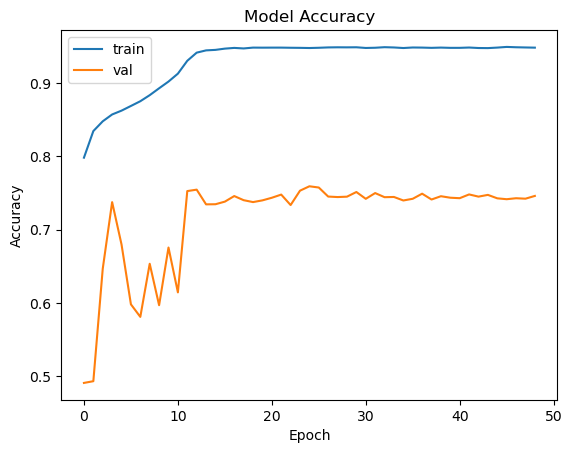

In [548]:
plt.plot(acc)
plt.plot(val_acc)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

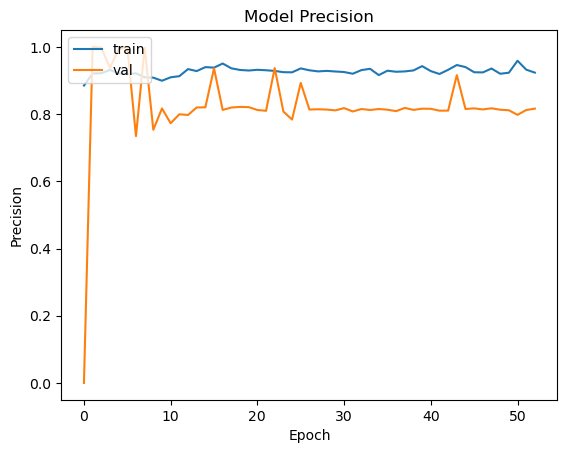

In [541]:
plt.plot(precision)
plt.plot(val_precision)

plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

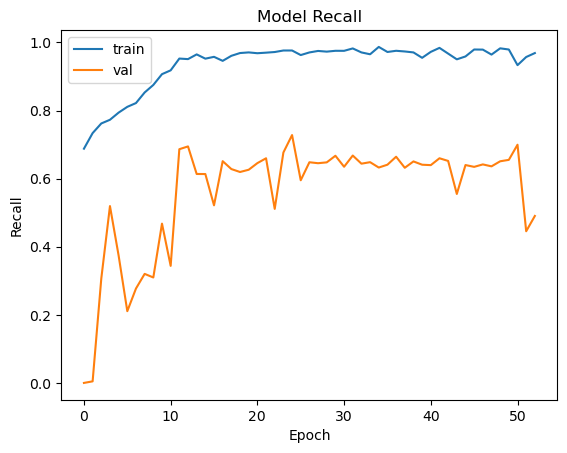

In [542]:
plt.plot(recall)
plt.plot(val_recall)

plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

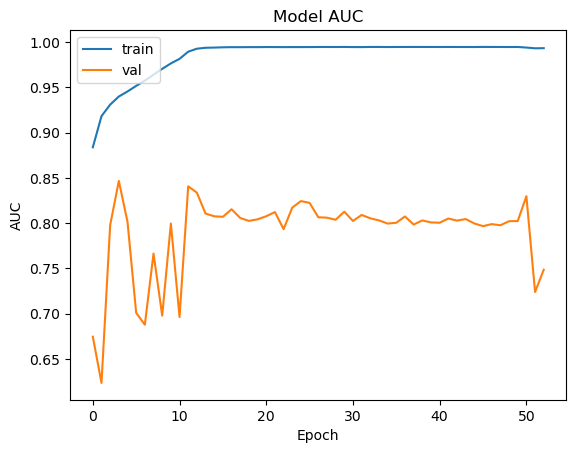

In [543]:
plt.plot(auc)
plt.plot(val_auc)

plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

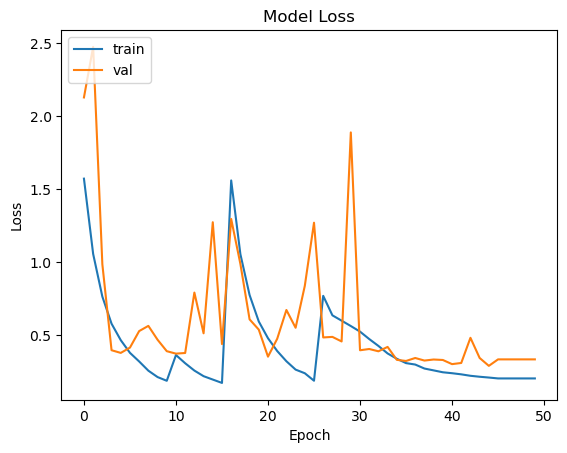

In [544]:
plt.plot(loss)
plt.plot(val_loss)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [545]:
print(f'Loss: {loss[-1]:.4f}')
print(f'Accuracy: {acc[-1]:.4f}')
print(f'Precision: {precision[-1]:.4f}')
print(f'Recall: {recall[-1]:.4f}')
print(f'AUC: {auc[-1]:.4f}')
print('--------------------')
print(f'False Positives: {false_positives[-1]}')
print(f'False Negatives: {false_negatives[-1]}')
print(f'True Positives: {true_positives[-1]}')
print(f'True Negatives: {true_negatives[-1]}')
print('--------------------')
print(f'Validation False Positives: {val_false_positives[-1]}')
print(f'Validation False Negatives: {val_false_negatives[-1]}')
print(f'Validation True Positives: {val_true_positives[-1]}')
print(f'Validation True Negatives: {val_true_negatives[-1]}')

Loss: 0.2021
Accuracy: 0.9485
Precision: 0.9234
Recall: 0.9687
AUC: 0.9935
--------------------
False Positives: 5153.0
False Negatives: 2009.0
True Positives: 62161.0
True Negatives: 58447.0
--------------------
Validation False Positives: 1817.0
Validation False Negatives: 8394.0
Validation True Positives: 8076.0
Validation True Negatives: 14068.0


# Testing

### Resnet50V2

In [480]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = model.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

2023-04-10 11:28:09.742164: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at segment_reduction_ops_impl.h:476 : INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [64]
2023-04-10 11:28:09.742467: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [64]
	 [[{{node UnsortedSegmentSum_1}}]]
2023-04-10 11:28:09.742504: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at segment_reduction_ops_impl.h:476 : INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [64]


InvalidArgumentError: Graph execution error:

Detected at node 'UnsortedSegmentSum_1' defined at (most recent call last):
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3507/3325004759.py", line 1, in <module>
      loss, acc, prec, rec, auc, fn, fp, tn, tp = model.evaluate(test_dataset_cdfv2)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/training.py", line 2072, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/training.py", line 1852, in test_function
      return step_function(self, iterator)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/training.py", line 1836, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/training.py", line 1824, in run_step
      outputs = model.test_step(data)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/metrics/confusion_metrics.py", line 1485, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 684, in update_confusion_matrix_variables
      return _update_confusion_matrix_variables_optimized(
    File "/home/fyp/miniconda3/envs/tf12/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 473, in _update_confusion_matrix_variables_optimized
      fp_bucket_v = tf.math.unsorted_segment_sum(
Node: 'UnsortedSegmentSum_1'
data.shape = [32] does not start with segment_ids.shape = [64]
	 [[{{node UnsortedSegmentSum_1}}]] [Op:__inference_test_function_2461888]

### Resnet-18

In [485]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = model.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

2023-04-10 11:30:57.656842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16239]
	 [[{{node Placeholder/_0}}]]
2023-04-10 11:30:57.657344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16239]
	 [[{{node Placeholder/_4}}]]


508/508 [==============================] - 43s 84ms/step - loss: 1.2566 - categorical_accuracy: 0.6274 - precision_58: 0.6274 - recall_58: 0.6274 - auc_58: 0.6584 - false_negatives_58: 6050.0000 - false_positives_58: 6050.0000 - true_negatives_58: 10189.0000 - true_positives_58: 10189.0000
Loss: 1.2566
Accuracy: 0.6274
Precision: 0.6274
Recall: 0.6274
AUC: 0.6584
--------------------
False Positives: 6050.0
False Negatives: 6050.0
True Positives: 10189.0
True Negatives: 10189.0


## Logic

In [38]:
def predict_class(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                   
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    prediction = model.predict(img_tensor)
    return prediction                                      

In [39]:
def testing(ds, main_segment):
    actual = []
    predicted = []
    
    for class_label in CLASS:
        final_actual = [1, 0] if class_label == CLASS_REAL else [0, 1]

        src_dir = ds + DS_TEMPORAL + DS_TEST + main_segment + class_label

        for vid_dir in os.listdir(src_dir):
            all_segment_softmax = []

            for child_segment in os.listdir(f'{src_dir}{vid_dir}'):
                segment_sum = [0, 0]
                frames_in_segment = 0

                # obtain individual image prediction
                for image in os.listdir(f'{src_dir}{vid_dir}/{child_segment}'):
                    pred_class = predict_class(f'{src_dir}{vid_dir}/{child_segment}/{image}')
                    
                    # compute segment sum
                    segment_sum[0] += pred_class[0]
                    segment_sum[1] += pred_class[1]

                    frames_in_segment += 1
                
                #compute segment average
                segment_sum[0] /= frames_in_segment
                segment_sum[1] /= frames_in_segment

                #compute softmax of segment
                segment_sum = softmax(np.array(segment_sum))
                all_segment_softmax.append(segment_sum)

            # compute segment wise sum
            final_pred = [0, 0]
            for pred in all_segment_softmax:
                final_pred[0] += pred[0]
                final_pred[1] += pred[1]

            #compute overall softmax
            final_pred = softmax(np.array(final_pred))

            predicted.append(final_pred)
            actual.append(final_actual)

    return actual, predicted
    

In [ ]:
actual, predicted = testing(DS_CDFV1, SEG_1)

In [40]:
def metrics(actual, predicted):
    m = keras.metrics.CategoricalAccuracy()
    m.update_state(actual, predicted)
    print(f'Categorical Accuracy - {m.result().numpy()}')
    
    m = keras.metrics.Precision()
    m.update_state(actual, predicted)
    print(f'Precision - {m.result().numpy()}')

    m = keras.metrics.Recall()
    m.update_state(actual, predicted)
    print(f'Recall - {m.result().numpy()}')

    m = keras.metrics.AUC()
    m.update_state(actual, predicted)
    print(f'AUC - {m.result().numpy()}')

In [ ]:
metrics(actual, predicted)

## Obtaining Test video scores

In [14]:
class VideoScore():
    def __init__(self, filename, score, true_class, fake_on_lower_half = True):
        self.filename = filename
        self.score = score
        self.true_class = true_class
        self.fake_on_lower_half = fake_on_lower_half

    def get_filename(self):
        return self.filename
    
    def get_score(self):
        return self.score
    
    def get_true_class(self):
        return self.true_class
    
    def get_fake_on_lower_half(self):
        return self.fake_on_lower_half

In [15]:
def get_residuals(fp, num_segments):
    vid_container = av.open(fp)
    vid_stream = vid_container.streams.video[0]
    frame_count = vid_stream.frames

    segment_dividers = get_segment_dividers(frame_count, num_segments)

    vid_container.seek(0)
    frame_list = [frame.to_image() for frame in vid_container.decode()]

    residuals = []
    start_index = 0
    for sd in segment_dividers:
        residuals.append(frame_list[start_index:sd])
        start_index = sd
    
    residuals.append(frame_list[start_index:])

    return residuals

In [202]:
def get_video_score_4(model, fp):
    residuals = get_residuals(fp, num_segments=3)

    fake_seg_count = 0
    real_seg_count = 0

    results = []
    vid_score = []
    for residual_set in residuals:
        tf_frames = []

        for frame in residual_set:
            tf_frames.append(img_to_array(tf.image.resize(frame, size = [224, 224])))

        tf_frames = np.asarray(tf_frames)
        result = model.predict(tf_frames, verbose=0)

        # print(result)
        # print('---')

        result = np.average(result, axis=0)
        results.append(result)

        # print(result)
        # print('===')

        if (result[0] > result[1]):
            fake_seg_count += 1
        else:
            real_seg_count += 1

    label_index = 1 if real_seg_count > fake_seg_count else 0
    for seg_score in results:
        if seg_score[label_index] >= seg_score[1 - label_index]:
            vid_score.append(seg_score[label_index])

    return np.average(vid_score)      


In [235]:
def get_video_score_3(model, fp):
    residuals = get_residuals(fp, num_segments=3)

    results = []
    for residual_set in residuals:
        tf_frames = []

        for frame in residual_set:
            tf_frames.append(img_to_array(tf.image.resize(frame, size = [224, 224])))

        tf_frames = np.asarray(tf_frames)
        result = model.predict(tf_frames, verbose=0)
        np.sum(result, axis=0)



In [ ]:
def get_video_score_2(model, fp, n):
    residuals = get_residuals(fp, num_segments=n)

    results = []
    for residual_set in residuals:
        tf_frames = []

        for frame in residual_set:
            tf_frames.append(img_to_array(tf.image.resize(frame, size = [224, 224])))

        tf_frames = np.asarray(tf_frames)
        result = model.predict(tf_frames, verbose=0)
        results.append(np.average(result))

    max_val = np.max(results)
    min_val = np.min(results)

    return max_val if 1 - max_val < min_val else min_val

In [230]:
def get_video_score(model, fp):
    frames = extract_snippets(fp, num_segments=4, num_snippets=1)

    tf_frames = []
    for frame in frames:
        tf_frames.append(img_to_array(tf.image.resize(frame, size = [224, 224])))

    tf_frames = np.asarray(tf_frames)
    # tf_frames = tf.convert_to_tensor(tf_frames)
    results = model.predict(tf_frames, verbose=0)

    return np.average(results)

In [77]:
def get_video_score_new(model, fp, n):
    residuals = get_residuals(fp, num_segments=n)

    results = []
    for residual_set in residuals:
        tf_frames = []

        for frame in residual_set:
            tf_frames.append(img_to_array(tf.image.resize(frame, size = [224, 224])))

        tf_frames = np.asarray(tf_frames)
        result = model.predict(tf_frames, verbose=0)

        rfake, rreal = [], []
        for rframe in result:
            if rframe < 0.5:
                rfake.append(rframe)
            else:
                rreal.append(rframe)

        avg = np.average(rfake) if len(rfake) > len(rreal) else np.average(rreal)
        # avg = np.average(result)

        results.append(avg)

    sreal = [x for x in results if x >= 0.5]
    sfake = [x for x in results if x < 0.5]

    return np.average(sreal) if len(sreal) > len(sfake) else np.average(sfake)

In [78]:
def get_test_scores(dataset, split, model, n):
    video_scores = []

    for class_dir in CLASS:
        print(f'Class started: {class_dir}')
    
        vid_dir = dataset + DS_FRAME_DIFF + split + class_dir
        for video in os.listdir(vid_dir):
            fp = vid_dir + video

            video_score = VideoScore(video, 
                                    get_video_score_new(model, fp, n),
                                    class_dir)
            
            video_scores.append(video_score)

    return video_scores

In [84]:
# temporal_model_test_scores = get_test_scores(DS_CDFV2, DS_TEST, model, 2)
# with open(TEST_SCORE_PATH + 'temporal_scores_test_final_sig_seg2_new.pkl', 'wb') as f:
#     pickle.dump(temporal_model_test_scores, f)

# print('done')

# temporal_model_test_scores = get_test_scores(DS_CDFV2, DS_TEST, model, 4)
# with open(TEST_SCORE_PATH + 'temporal_scores_test_final_sig_seg4_new.pkl', 'wb') as f:
#     pickle.dump(temporal_model_test_scores, f)

# print('done')

temporal_model_test_scores = get_test_scores(DS_CDFV2, DS_TEST, model, 5)
with open(TEST_SCORE_PATH + 'temporal_scores_test_final_sig_seg5_new.pkl', 'wb') as f:
    pickle.dump(temporal_model_test_scores, f)

# print('done')

# temporal_model_test_scores = get_test_scores(DS_CDFV2, DS_TEST, model, 1)
# with open(TEST_SCORE_PATH + 'temporal_scores_test_final_sig_seg1_new.pkl', 'wb') as f:
#     pickle.dump(temporal_model_test_scores, f)

# print('done')

# temporal_model_test_scores = get_test_scores(DS_CDFV2, DS_TEST, model, 3)
# with open(TEST_SCORE_PATH + 'temporal_scores_test_final_sig_seg3_avgcomb.pkl', 'wb') as f:
#     pickle.dump(temporal_model_test_scores, f)

Class started: real/
Class started: fake/


In [257]:
temporal_model_test_scores = get_test_scores(DS_CDFV2, DS_TRAIN, model)

with open(TEST_SCORE_PATH + 'temporal_scores_train_final_sig', 'wb') as f:
    pickle.dump(temporal_model_test_scores, f)

Class started: real/
Class started: fake/


In [85]:
test_scores = []
with open(TEST_SCORE_PATH + 'temporal_scores_test_final_sig_seg5_new.pkl', 'rb') as f:
    test_scores = pickle.load(f)

In [86]:
true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

for t in test_scores:
    if t.get_score() <= 0.5:
        if t.get_true_class() == CLASS_FAKE:
            true_fake += 1
        else:
            false_fake += 1
    elif t.get_true_class() == CLASS_REAL:
            true_real += 1
    else:
        false_real += 1

In [87]:
accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)

In [88]:
print(f'True Fake:{true_fake}')
print(f'True Real:{true_real}')
print(f'False Fake:{false_fake}')
print(f'False Real:{false_real}')
print(f'---')
print(f'Accuracy: {accuracy}')

True Fake:310
True Real:54
False Fake:124
False Real:30
---
Accuracy: 0.7027027027027027


In [72]:
def get_segment_score(src_dir, model):

    in_arr = []
    for frame in os.listdir(src_dir):
        f = load_img(f'{src_dir}/{frame}', target_size=(224, 224))
        f = img_to_array(f)
        in_arr.append(f)

    in_arr = np.asarray(in_arr)
    pred = model.predict(tf.convert_to_tensor(in_arr), verbose=0, batch_size=64)

    # count_real = 0
    # count_fake = 0

    # for p in pred:
    #     if p < 0.5:
    #         count_fake += 1
    #     else:
    #         count_real += 1

    # print(count_real)
    # print(count_fake)

    pred = np.average(pred)
    # return softmax(pred[0])       [0.3, 0.7] [0.4, 0.7] -> [0.7, 1.4]
    return pred

    # model results give 2D array, 1st dim => input index, 2nd dim => softmax results

    # predictions = []
    # img_array = []
    # for frame in os.listdir(src_dir):
    #     f = load_img(f'{src_dir}/{frame}', target_size=(224, 224))
    #     # f = img_to_array(f)                   
    #     # f = np.expand_dims(f, axis=0)
    #     img_array.append(tf.convert_to_tensor(f))

    # tf_array = tf.convert_to_tensor(img_array)
    # # print(tf_array)
    # predictions = model.predict(tf_array, verbose=2, batch_size=128)
    # # predictions.append(prediction[0])
    # print(predictions)
    
    # # predictions = np.average(predictions, axis=0, keepdims=True)
    # # predictions = softmax(predictions)
    
    # # return predictions[0]

In [ ]:
tmp_src = DS_CDFV2 + DS_TEMPORAL + DS_TEST + SEG_1 + CLASS_REAL
for tmp_vid_dir in os.listdir(tmp_src):
    for child_segment in os.listdir(f'{tmp_src}{tmp_vid_dir}'):
        score = get_segment_score(f'{tmp_src}{tmp_vid_dir}/{child_segment}', model)
        print(score)

        print('----')



In [74]:
def get_test_scores(dataset, model, main_segment):
    video_scores = []

    for class_label in CLASS:
        print(f'Started Testing class: {class_label}')
        
        src_dir = dataset + DS_TEMPORAL + DS_TEST + main_segment + class_label

        vid_count = 0
        for vid_dir in os.listdir(src_dir):
            segment_scores = []

            for child_segment in os.listdir(f'{src_dir}{vid_dir}'):
                segment_score = get_segment_score(f'{src_dir}{vid_dir}/{child_segment}', model)
                segment_scores.append(segment_score)
            
            prediction = np.sum(segment_scores)
            prediction = 1 / (1 + np.exp(-prediction))

            video_score = VideoScore(vid_dir, prediction, class_label)
            video_scores.append(video_score)

            vid_count += 1
            if vid_count % 10 == 0:
                print(f'Vid count: {vid_count}')
    
    return video_scores

In [63]:
for main_segment in SEGMENTS:
    # if main_segment == SEG_1 or main_segment == SEG_2:
    #     continue
    
    print(f'Started Testing : {main_segment}')

    test_scores = get_test_scores(DS_CDFV1, model, main_segment)
    with open(TEST_SCORE_PATH + 'temporal_test/' + main_segment + 'temporal_test_scores_sig', 'wb') as f:
        pickle.dump(test_scores, f)
    
    print(f'Finished Testing : {main_segment}')

Started Testing : seg_1/
Started Testing class: real/
Vid count: 10
Vid count: 20
Vid count: 30
Started Testing class: fake/
Vid count: 10
Vid count: 20
Vid count: 30
Vid count: 40
Vid count: 50
Vid count: 60
Finished Testing : seg_1/
Started Testing : seg_2/
Started Testing class: real/
Vid count: 10
Vid count: 20
Vid count: 30
Started Testing class: fake/
Vid count: 10
Vid count: 20
Vid count: 30
Vid count: 40
Vid count: 50
Vid count: 60
Finished Testing : seg_2/
Started Testing : seg_3/
Started Testing class: real/
Vid count: 10
Vid count: 20
Vid count: 30
Started Testing class: fake/
Vid count: 10
Vid count: 20
Vid count: 30
Vid count: 40
Vid count: 50
Vid count: 60
Finished Testing : seg_3/
Started Testing : seg_4/
Started Testing class: real/
Vid count: 10
Vid count: 20
Vid count: 30
Started Testing class: fake/
Vid count: 10
Vid count: 20
Vid count: 30
Vid count: 40
Vid count: 50
Vid count: 60
Finished Testing : seg_4/
Started Testing : seg_5/
Started Testing class: real/
Vid co

In [75]:
main_segment = SEG_3
test_scores = get_test_scores(DS_CDFV2, model, main_segment)
with open(TEST_SCORE_PATH + 'temporal_test_2/' + main_segment + 'temporal_test_scores_sig_2', 'wb') as f:
    pickle.dump(test_scores, f)

print(f'Finished Testing : {main_segment}')

Started Testing class: real/
Vid count: 10
Vid count: 20
Vid count: 30
Started Testing class: fake/
Vid count: 10
Vid count: 20
Vid count: 30
Vid count: 40
Vid count: 50
Vid count: 60
Finished Testing : seg_3/


In [37]:
for vid in test_scores:
    print(vid.get_score())

0.6651954341782585
0.6467099263279789
0.6417783162435646
0.5982910499956547
0.6230699128771782
0.6285954611098798
0.5622503908674045
0.6251700498773226
0.6209454104334511
0.5520719163049085
0.6297756117776321
0.5402590885257074
0.6616033126982428
0.5447821954598929
0.5592165615833935
0.6382313174329287
0.5398071693461429
0.5978740376123035
0.611182310162887
0.5207086972316699
0.5689961236048379
0.663994837869722
0.5265630816145006
0.641647001014873
0.5600346624847367
0.587425852314982
0.569753898147096
0.6122912873425542
0.5475056262437995
0.6128436374996009
0.5359762689874265
0.577792944776455
0.5461772124140702
0.6246151957162605
0.6149884580721978
0.554834500095657
0.5505227667617947
0.515423789980889
0.5109731105880263
0.6582903434636754
0.6451224361404495
0.6291342677190027
0.5428875303734172
0.5425648567185737
0.5117116312566289
0.5842833256698721
0.5997766801735337
0.5194233085399127
0.5807784102897225
0.5606042967191521
0.5659379562957283
0.546470394564981
0.6182063080109066
0.

### Test Metrics

In [76]:
with open(TEST_SCORE_PATH + 'temporal_test_2/' + SEG_1 + 'temporal_test_scores_sig_2', 'rb') as f:
    temporal_scores_test = pickle.load(f)
    print(len(temporal_scores_test))

103


In [77]:
true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

for t in temporal_scores_test:
    if t.get_score() <= 0.5:
        if t.get_true_class() == CLASS_FAKE:
            true_fake += 1
        else:
            false_fake += 1
    elif t.get_true_class() == CLASS_REAL:
            true_real += 1
    else:
        false_real += 1

In [78]:
accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)

In [79]:
print(f'True Fake:{true_fake}')
print(f'True Real:{true_real}')
print(f'False Fake:{false_fake}')
print(f'False Real:{false_real}')
print(f'---')
print(f'Accuracy: {accuracy}')

True Fake:0
True Real:35
False Fake:0
False Real:68
---
Accuracy: 0.33980582524271846


same values? exactly same values. lol

In [48]:
def get_test_metrics(segment):
    with open(TEST_SCORE_PATH + 'temporal_test/' + segment + 'temporal_test_scores', 'rb') as f:
        temporal_scores_test = pickle.load(f)

    true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

    for t in temporal_scores_test:
        if t.get_score() <= 0.5:
            if t.get_true_class() == CLASS_FAKE:
                true_fake += 1
            else:
                false_fake += 1
        elif t.get_true_class() == CLASS_REAL:
                true_real += 1
        else:
            false_real += 1

    accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)

    print(f'---------{segment}-------------')
    print(f'True Fake:{true_fake}')
    print(f'True Real:{true_real}')
    print(f'False Fake:{false_fake}')
    print(f'False Real:{false_real}')
    print(f'---')
    print(f'Accuracy: {accuracy}')
    print(f'-------------------------')
    print(f'-------------------------')

In [49]:
for segment in SEGMENTS:
    get_test_metrics(segment)

---------seg_1/-------------
True Fake:54
True Real:23
False Fake:15
False Real:8
---
Accuracy: 0.77
-------------------------
-------------------------
---------seg_2/-------------
True Fake:54
True Real:26
False Fake:12
False Real:8
---
Accuracy: 0.8
-------------------------
-------------------------
---------seg_3/-------------
True Fake:0
True Real:38
False Fake:0
False Real:62
---
Accuracy: 0.38
-------------------------
-------------------------
---------seg_4/-------------
True Fake:0
True Real:38
False Fake:0
False Real:62
---
Accuracy: 0.38
-------------------------
-------------------------
---------seg_5/-------------
True Fake:0
True Real:38
False Fake:0
False Real:62
---
Accuracy: 0.38
-------------------------
-------------------------


In [56]:
def get_segment_score(src_dir, model):

    in_arr = []
    for frame in os.listdir(src_dir):
        f = load_img(f'{src_dir}/{frame}', target_size=(224, 224))
        f = img_to_array(f)
        in_arr.append(f)

    in_arr = np.asarray(in_arr)
    pred = model.predict(tf.convert_to_tensor(in_arr), verbose=0, batch_size=64)
    return pred

In [64]:
def get_test_scores(dataset, model, main_segment):
    video_scores = []

    for class_label in CLASS:
        if class_label == CLASS_REAL:
            continue
        
        print(f'Started Testing class: {class_label}')
        
        src_dir = dataset + DS_TEMPORAL + DS_TEST + main_segment + class_label

        vid_count = 0
        for vid_dir in os.listdir(src_dir):
            segment_scores = []

            for child_segment in os.listdir(f'{src_dir}{vid_dir}'):
                segment_score = get_segment_score(f'{src_dir}{vid_dir}/{child_segment}', model)
                segment_scores.append(segment_score)
            
            print(segment_scores)
            # prediction = np.sum(segment_scores, axis=0, keepdims=True)
            # prediction = softmax(prediction)

            # video_score = VideoScore(vid_dir, prediction[0][1], class_label)
            # video_scores.append(video_score)

            # vid_count += 1
            # if vid_count % 10 == 0:
                # print(f'Vid count: {vid_count}')
    
    return video_scores

In [66]:
get_test_scores(DS_CDFV2, model, SEG_1)

Started Testing class: fake/
[array([[0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [6.6755190e-02, 9.3324476e-01],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [6.6755190e-02, 9.3324476e-01],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+

KeyboardInterrupt: 

# New Testing Strategy

In [ ]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = model.evaluate(train_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

In [513]:
def get_individual_segment_score_69(scores):
    real_segments, fake_segments = 0, 0
    
    for seg_score in scores:
        if seg_score[1] >= seg_score[0]:
            real_segments += 1
        else:
            fake_segments += 1
    
    label_index = 1 if real_segments > fake_segments else 0
    vid_score = []

    for seg_score in scores:
        if seg_score[label_index] >= seg_score[1 - label_index]:
            vid_score.append(seg_score)
    
    vid_score = np.average(vid_score, axis=0, keepdims=True)    
    return vid_score

In [520]:
def get_segment_score_69(src_dir, model):

    frames = []
    for frame in os.listdir(src_dir):
        f = load_img(f'{src_dir}/{frame}', target_size=(224, 224))
        f = img_to_array(f)
        frames.append(f)
    
    frames = np.asarray(frames)
    pred = model.predict(tf.convert_to_tensor(frames), verbose=0, batch_size=64)
    # pred = np.average(pred, axis=0, keepdims=True)
    
    pred = get_individual_segment_score_69(pred)    
    return pred[0]

## sigmoid

In [502]:
# SIGMOID
# for sigmoid output
def get_video_score_69(segment_scores, actual_label):
    real_segments, fake_segments = 0, 0
    
    for seg_score in segment_scores:
        if seg_score > 0.5:
            real_segments += 1
        else:
            fake_segments += 1
    
    vid_score = []

    for seg_score in segment_scores:
        if real_segments > fake_segments and seg_score > 0.5:
            vid_score.append(seg_score)
        elif fake_segments > real_segments and seg_score < 0.5:
            vid_score.append(seg_score)
    
    vid_score = np.average(vid_score)    
    return vid_score

## softmax

In [525]:
# SOFTMAX
# softmax output from model = [prob fake, prob real]
# find the majority segments, final score is the average score of the majority segments

def get_video_score_69(segment_scores, actual_label):
    real_segments, fake_segments = 0, 0
    
    for seg_score in segment_scores:
        if seg_score[1] >= seg_score[0]:
            real_segments += 1
        else:
            fake_segments += 1
    
    label_index = 1 if real_segments > fake_segments else 0
    vid_score = []

    for seg_score in segment_scores:
        if seg_score[label_index] >= seg_score[1 - label_index]:
            vid_score.append(seg_score[1])
    
    vid_score = np.average(vid_score)    
    return vid_score

In [561]:
actual = []
predicted = []

In [563]:
class_label = CLASS_REAL
actual_score = 1

tmp_src = DS_CDFV2 + 'dataset_temporal_2/' + DS_TEST + SEG_3 + class_label

for tmp_vid_dir in os.listdir(tmp_src):
    segment_scores = []

    for child_segment in os.listdir(f'{tmp_src}{tmp_vid_dir}'):
        segment_score = get_segment_score_69(f'{tmp_src}{tmp_vid_dir}/{child_segment}', model)
        print(segment_score)

        segment_scores.append(segment_score)
    
    video_score = get_video_score_69(segment_scores, CLASS_REAL)
    print(video_score)
    print('-------------')
    predicted.append(video_score)
    actual.append(actual_score)

[0.0333409 0.9666591]
[0.86494905 0.13505097]
[0.04239707 0.95760316]
0.96213114
-------------
[0.8453216  0.15467836]
[0.06998016 0.93001974]
[0.8506059  0.14939412]
0.15203625
-------------
[0.95245814 0.04754221]
[0.913523   0.08647707]
[0.8806442  0.11935587]
0.08445839
-------------
[0.855511   0.14448906]
[0.82902074 0.17097943]
[0.89846    0.10154028]
0.13900292
-------------
[0.10087132 0.8991287 ]
[0.09715427 0.90284544]
[0.8756234  0.12437654]
0.900987
-------------
[0.0429612 0.9570389]
[0.05179475 0.9482052 ]
[0.04643882 0.95356095]
0.95293504
-------------
[0.92924684 0.07075343]
[0.92644286 0.07355702]
[0.8941097  0.10588998]
0.08340014
-------------
[0.90600514 0.09399506]
[0.9258691  0.07413074]
[0.8848323  0.11516785]
0.09443122
-------------
[0.8808821  0.11911801]
[0.8144783  0.18552172]
[0.76950896 0.23049106]
0.17837693
-------------
[0.9662155  0.03378454]
[0.9505378  0.04946211]
[0.96398336 0.03601671]
0.03975445
-------------
[0.9110418  0.08895827]
[0.91411483 

In [564]:
print(predicted, actual)

[0.07114947, 0.10162524, 0.051668275, 0.06817927, 0.86119044, 0.13710277, 0.13583206, 0.06080124, 0.066212066, 0.041122515, 0.08283427, 0.097834386, 0.05555585, 0.06870221, 0.08008039, 0.07498502, 0.051866826, 0.85990703, 0.11643254, 0.05770186, 0.07489892, 0.10535691, 0.85011506, 0.8472458, 0.06681501, 0.073826455, 0.10231271, 0.14589868, 0.09668218, 0.8446742, 0.06442205, 0.123388045, 0.123392425, 0.07015394, 0.10744139, 0.070978224, 0.9298935, 0.1129497, 0.1017057, 0.10087311, 0.05969602, 0.100688554, 0.92087007, 0.09159558, 0.08564567, 0.04997374, 0.08462821, 0.09951654, 0.082205296, 0.10056642, 0.066302426, 0.058751088, 0.12377425, 0.06810223, 0.084594764, 0.1430038, 0.98211956, 0.04265666, 0.11115166, 0.091521986, 0.10065017, 0.8547244, 0.06815847, 0.09037018, 0.16019623, 0.086565994, 0.88329387, 0.07145161, 0.96213114, 0.15203625, 0.08445839, 0.13900292, 0.900987, 0.95293504, 0.08340014, 0.09443122, 0.17837693, 0.03975445, 0.104213096, 0.0943112, 0.08970811, 0.06523552, 0.101574

In [565]:
true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

for p,a in zip(predicted, actual):
    if p <= 0.5:
        if a == 0:
            true_fake += 1
        else:
            false_fake += 1
    elif a == 1:
        true_real += 1
    else:
        false_real += 1

In [566]:
accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)

In [567]:
print(f'True Fake:{true_fake}')
print(f'True Real:{true_real}')
print(f'False Fake:{false_fake}')
print(f'False Real:{false_real}')
print(f'---')
print(f'Accuracy: {accuracy}')

True Fake:58
True Real:4
False Fake:31
False Real:10
---
Accuracy: 0.6019417475728155


In [529]:
model.summary((224, 224, 3))

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1134 (Conv2D)        (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 block_136 (Block)           (None, 55, 55, 64)        73856     
                                                                 
 block_137 (Block)           (None, 55, 55, 64)        73856     
                                                                 
 block_138 (Block)           (None, 28, 28, 128)       229760    
                                                          

# 3-05-2023 New Testing Strategy

In [438]:
threshold = 0.5

In [439]:
class VideoScore():
    def __init__(self, filename, score, true_class, fake_on_lower_half = True):
        self.filename = filename
        self.score = score
        self.true_class = true_class
        self.fake_on_lower_half = fake_on_lower_half

    def get_filename(self):
        return self.filename
    
    def get_score(self):
        return self.score
    
    def get_true_class(self):
        return self.true_class
    
    def get_fake_on_lower_half(self):
        return self.fake_on_lower_half

In [440]:
def majority_average_score(scores):
    # real_scores, fake_scores = 0, 0
    
    # for score in scores:
    #     if score >= threshold:
    #         real_scores += 1
    #     else:
    #         fake_scores += 1
    
    # final_score = []

    # for score in scores:
    #     if (real_scores >= fake_scores and score >= threshold) or (fake_scores > real_scores and score < threshold): 
    #         final_score.append(score)

    # final_score = np.average(final_score)    
    # return final_score

    max_val = np.max(scores)
    min_val = np.min(scores)

    return max_val if 1 - max_val < min_val else min_val

In [441]:
def compute_segment_score(child_segment, model):

    frames = []
    for frame in child_segment:
        frames.append(img_to_array(frame))
    
    frames = np.asarray(frames)
    pred = model.predict(frames, verbose=0, batch_size=64)
    pred = list(np.concatenate(pred).flat)
    # print(pred)
    # print(np.average(pred))
    
    pred = np.average(pred)

    # pred = majority_average_score(pred)
    return pred

In [442]:
def get_frames(src_dir, video, no_of_segments):
    
    video_container = av.open(src_dir + video)
    total_frames = video_container.streams.video[0].frames
    frames_per_segment = total_frames / no_of_segments

    # print(frames_per_segment)

    index = 0
    segments, frames = [], []

    for frame in video_container.decode():
        if index < frames_per_segment:
            frames.append(frame.to_image())
        else:
            segments.append(frames)
            frames = []
            frames.append(frame.to_image())
            index = 0
            
        index += 1

    if frames:
        segments.append(frames)
    
    return segments

In [443]:
def calculate_scores(src_dir, model, no_of_segments = 1):
    video_scores = []

    for class_label in CLASS:
        tmp_src = src_dir + class_label

        for video in os.listdir(tmp_src):
            segments = get_frames(tmp_src, video, no_of_segments)     

            segment_scores = []

            for child_segment in segments:
                segment_score = compute_segment_score(child_segment, model)
                segment_scores.append(segment_score)
            
            final_score = majority_average_score(segment_scores)
            # if final_score < 0.5:
                # print(f'{video} {final_score}')
            # return 
            
            video_score = VideoScore(video, final_score, class_label)
            video_scores.append(video_score)

    return video_scores

In [444]:
src_dir = DS_CDFV2 + 'dataset_face_residuals/' + 'test_dataset_acc_off/'
no_of_segments = 2

In [445]:
# TODO : save segment wise scores
scores = calculate_scores(src_dir, model, no_of_segments)

## Saving Train and Test scores

In [549]:
src_dir = DS_CDFV2 + 'dataset_face_residuals/' + 'train_dataset_acc_off_videos/'
no_of_segments = 2

temporal_model_train_scores = calculate_scores(src_dir, model, no_of_segments)

In [552]:
with open(TEST_SCORE_PATH + 'temporal_final_scores/' + 'temporal_scores_train', 'wb') as f:
    pickle.dump(temporal_model_train_scores, f)

In [412]:
src_dir = DS_CDFV2 + 'dataset_face_residuals/' + 'test_dataset_acc_off/'
no_of_segments = 2

temporal_model_test_scores = calculate_scores(src_dir, model, no_of_segments)

In [425]:
with open(TEST_SCORE_PATH + 'temporal_final_scores/' + 'temporal_scores_test', 'wb') as f:
    pickle.dump(temporal_model_test_scores, f)

In [ ]:
tmp_src = src_dir + CLASS_FAKE
for video in os.listdir(tmp_src):
    segments = get_frames(tmp_src, video, no_of_segments)     

    segment_scores = []

    for child_segment in segments:
        segment_score = compute_segment_score(child_segment, model)
        segment_scores.append(segment_score)
    
    final_score = majority_average_score(segment_scores)
    print(f'{video} {final_score}')
    print('---------------------------------')

In [399]:
def calculate_metrics(scores):
    true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

    for vid_score in scores:
        score = vid_score.get_score()
        if score < threshold and vid_score.get_true_class() == CLASS_FAKE:
            true_fake += 1

        elif score >= threshold and vid_score.get_true_class() == CLASS_REAL:
            true_real += 1

        elif score < threshold and vid_score.get_true_class() == CLASS_REAL:
            false_fake += 1

        else:
            false_real += 1

    accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)
    precision = true_fake / (true_fake + false_fake)
    recall = true_fake / (true_fake + false_real)


    y_true = [0 if x.get_true_class() == CLASS_FAKE else 1 for x in scores]
    y_score = [0 if x.get_score() < threshold else 1 for x in scores]

    # auc = tf.keras.metrics.roc_auc_score(y_true, y_score)

    all_metrics = {}
    all_metrics['true_fake'] = true_fake    
    all_metrics['true_real'] = true_real
    all_metrics['false_fake'] = false_fake
    all_metrics['false_real'] = false_real
    all_metrics['accuracy'] = accuracy
    all_metrics['precision'] = precision
    all_metrics['recall'] = recall
    # all_metrics['AUC'] = auc

    return all_metrics

In [ ]:
scores = []

with open(TEST_SCORE_PATH + 'temporal_final_scores/' + 'temporal_scores_train', 'rb') as f:
    scores = pickle.load(f)

In [550]:
all_metrics = calculate_metrics(temporal_model_train_scores)

In [551]:
print(f'True Fake:{all_metrics["true_fake"]}')
print(f'True Real:{all_metrics["true_real"]}')
print(f'False Fake:{all_metrics["false_fake"]}')
print(f'False Real:{all_metrics["false_real"]}')
print(f'---')
print(f'Accuracy: {all_metrics["accuracy"]:.4f}')
print(f'Precision: {all_metrics["precision"]:.4f}')
print(f'Recall: {all_metrics["recall"]:.4f}')
# print(f'AUC Score: {all_metrics["AUC"]:.4f}')

True Fake:4240
True Real:544
False Fake:26
False Real:0
---
Accuracy: 0.9946
Precision: 0.9939
Recall: 1.0000


### When test dataset is frames

In [ ]:
def calculate_scores(src_dir, model):
    video_scores = []

    for class_label in CLASS:
        tmp_src = src_dir + class_label

        for vid_dir in os.listdir(tmp_src):
            segment_scores = []

            for child_segment in os.listdir(f'{tmp_src}{vid_dir}'):
                segment_score = segment_score(f'{tmp_src}{vid_dir}/{child_segment}', model)
                segment_scores.append(segment_score)
            
            final_score = majority_average_score(segment_scores)
            video_score = VideoScore(vid_dir, final_score, class_label)
            video_scores.append(video_score)
    
    return video_scores